In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import csv
import numpy as np


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import os

import scores

# Reading in the Data

In [2]:
path_f=os.getcwd()

path_f_1=os.path.join(path_f, 'data')


names=[]
for files_txts in os.listdir(path_f_1):
    if files_txts.endswith(".csv"):
        #print(files_txts)
        names.append(files_txts)
        
path_train=os.path.join(path_f_1, names[0])
path_test=os.path.join(path_f_1, names[1])

df_train=pd.read_csv(path_train)
df_train.shape

(2572, 99)

## Data Manipulation

 - Transforming the outcome to a numpy vector

In [3]:
stab_vector=df_train['stabilityVec'].values
y=[]
for x in stab_vector:
    #print(x)
    a=np.fromstring(x[1:-1],sep=',').astype(int)
    y.append(a)
y=np.array(y) 

df_tmp = pd.DataFrame(y, columns = ['A', 'A91B', 'A82B','A73B','A64B','A55B','A46B','A37B','A28B','A19B','B'])
stab_vec_list=[ 'A91B', 'A82B','A73B','A64B','A55B','A46B','A37B','A28B','A19B']

df_train=df_train.drop("stabilityVec",axis=1) #removing the results which originally are a string
feature_cols=list(df_train)

print(df_train.shape)

csvfile = csv.reader(open(path_train,'r'))
header = next(csvfile)

formulaA = []
formulaB = []

for row in csvfile:
    formulaA.append(row[0])
    formulaB.append(row[1])
formulas = formulaA + formulaB
formulas = list(set(formulas))

# -- /!\ need to save the dict as the ordering may difer at each run
formula2int = {}
int2formula = {}
for i, f in enumerate(formulas):
    formula2int[f] = i
    int2formula[i] = f

formulaAint = np.array([formula2int[x] for x in formulaA])
formulaBint = np.array([formula2int[x] for x in formulaB])

df_train['formulaA']=formulaAint
df_train['formulaB']=formulaBint

df_train=pd.concat([df_train, df_tmp],axis=1)
print(df_train.shape)

(2572, 98)
(2572, 109)


### Input Data Normalization and Feature Engineering


In [4]:
y_all=df_train[stab_vec_list]
df_tmp_stable = pd.DataFrame( columns = ['Stable_compunds'])
df_tmp_stable['Stable_compunds']=np.logical_not(y_all.sum(axis=1)==0).astype(int) ## A one means it has a stable value  a 0 

df_train=pd.concat([df_train, df_tmp_stable],axis=1)
print(df_train.shape)

df_train.head()

(2572, 110)


,formulaA,formulaB,formulaA_elements_AtomicVolume,formulaB_elements_AtomicVolume,formulaA_elements_AtomicWeight,formulaB_elements_AtomicWeight,formulaA_elements_BoilingT,formulaB_elements_BoilingT,formulaA_elements_BulkModulus,formulaB_elements_BulkModulus,...,A82B,A73B,A64B,A55B,A46B,A37B,A28B,A19B,B,Stable_compunds
0,47,81,37.433086,17.075648,227.0,107.868200,3473.0,2435.0,0.0,100.0,...,0,1,0,1,0,0,0,0,1,1
1,47,63,37.433086,16.594425,227.0,26.981539,3473.0,2792.0,0.0,76.0,...,0,1,0,0,0,0,0,0,1,1
2,47,77,37.433086,21.723966,227.0,74.921600,3473.0,887.0,0.0,22.0,...,0,0,0,0,0,0,0,0,1,0
3,47,22,37.433086,64.969282,227.0,137.327000,3473.0,2143.0,0.0,9.6,...,0,0,0,0,0,0,0,0,1,0
4,47,28,37.433086,35.483459,227.0,208.980400,3473.0,1837.0,0.0,31.0,...,0,0,0,0,0,0,0,0,1,0


Pearson Correlation to Identify the features that influence the most on the output 

(99, 99)


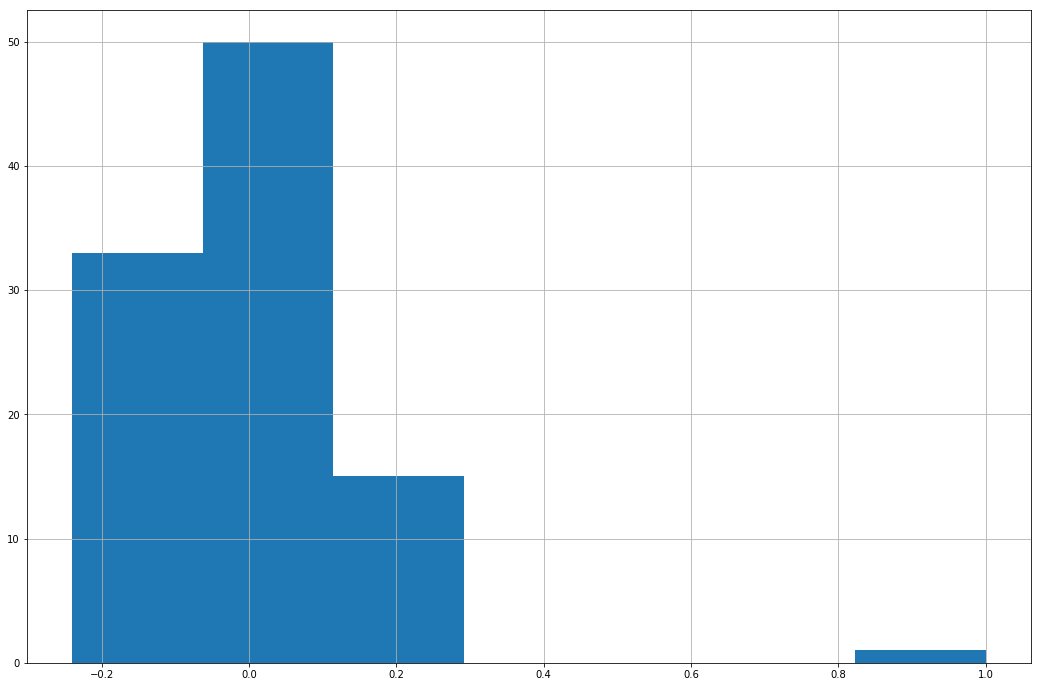

In [5]:
X_train_new=df_train[feature_cols]
y_new=df_train['Stable_compunds']

corr_df=pd.concat([X_train_new, y_new],axis=1)
a=corr_df.corr()
a['Stable_compunds'].hist(bins=7, figsize=(18, 12), xlabelsize=10)

print(a.shape)

In [ ]:
## Incorporating the Features that contribute the most based on a pearson correlation coefficient threshold
thr=.1
print(a[a['Stable_compunds'].abs()>thr].shape)
corr_variables=list(a[a['Stable_compunds'].abs()>thr].index)

del(corr_variables[-1])

print(corr_variables[-1])
print(a['avg_nearest_neighbor_distance_B'].iloc[-1])

In [ ]:
## Using Un-normalized data as input
X_train_new=df_train[corr_variables]

print(X_train_new.shape)





# Normalizing such that the magnitude is one
from sklearn.preprocessing import normalize

X_train_new_mag_1=normalize(X_train_new, axis=1) # vector magnitude is one
print(X_train_new_mag_1.shape)


## Normalizing by Zscore
from scipy.stats import zscore
X_train_new_Z_score=X_train_new.apply(zscore)
print(X_train_new_Z_score.shape)


## Normalizing by Zscore and then 0-1
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_train_new_Z_0_1=min_max_scaler.fit_transform(X_train_new_Z_score)
print(X_train_new_Z_0_1.shape)


## Normalizing so that range is 0-1
from sklearn import preprocessing
X_train_new_0_1=min_max_scaler.fit_transform(X_train_new)
print(X_train_new_0_1.shape)


## Normalizing so that range is -1 to 1
from sklearn import preprocessing
max_abs_scaler = preprocessing.MaxAbsScaler()
X_train_new_m1_p1=max_abs_scaler.fit_transform(X_train_new)
print(X_train_new_m1_p1.shape)







In [ ]:
# Using PCA as input
X_train_4_PCA=df_train[feature_cols]
print(X_train_4_PCA.shape)
X_train_new_mag_1_PCA=normalize(X_train_4_PCA, axis=1)
print(X_train_new_mag_1_PCA.shape)

pca = PCA()
pca.fit(X_train_new_mag_1_PCA)
components = pca.components_[:20,:]
new_data = np.dot(X_train_new_mag_1_PCA, components.T)
X_train_new_PCA=new_data

print(X_train_new_PCA.shape)

In [ ]:
## Using Pearson Correlation in PCA
df1= pd.DataFrame(data=X_train_new_PCA)
print(df1.shape)


corr_df_PCA=pd.concat([df1, y_new],axis=1)

print(corr_df_PCA.shape)
a_PCA=corr_df_PCA.corr()
#a_PCA['Stable_compunds'].hist(bins=7, figsize=(18, 12), xlabelsize=10)
a_PCA.shape

thr=.01
print(a_PCA[a_PCA['Stable_compunds'].abs()>thr].shape)
corr_variables_PCA=list(a_PCA[a_PCA['Stable_compunds'].abs()>thr].index)

del(corr_variables_PCA[-1])
print(corr_variables_PCA)

X_train_PCA_PC=df1[corr_variables_PCA]
X_train_PCA_PC.shape

## Analyzing the Output Data Recieved


In [ ]:
y = df_train[stab_vec_list]
print(y.sum(axis=1).value_counts())
## Observing how many element pairs produce a stable compound per % and overall
f,a = plt.subplots(3,3)
f.subplots_adjust(hspace=0.4, wspace=0.4)
a = a.ravel()
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

y_all=df_train[stab_vec_list]

for count,ax in enumerate(a):
    
    y = df_train[stab_vec_list[count]]
    #print(y.value_counts())
    hist_1, bin_edges_1 = np.histogram(y)
    freq_1=hist_1/y.size
    
    ax.hist(y.values, bins=10, label='all elements')


    #ax.xlim(min(bin_edges), max(bin_edges))
    #ax.title(stab_vec_list[count])
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Value')
    
    

#for count in range(9):

    #y = df_train[stab_vec_list[count]]
    stable_comp=df_train.loc[y==1,['formulaA','formulaB']]
    #print('Compound being analyzed is',stab_vec_list[count])
    stable_comp_num=stable_comp.values
    stable_A=np.unique(stable_comp_num[:,0])
    stable_B=np.unique(stable_comp_num[:,1])
    df_unique= pd.DataFrame()
    #print(df_unique.shape)

    y_unique= pd.DataFrame()
    
    for cnt in range(stable_A.shape[0]):
        #print(stable_A[cnt])
        df_tmp=y.loc[df_train['formulaA']==stable_A[cnt]]
        y_unique=pd.concat([y_unique, df_tmp],axis=0)
        #print(df_tmp.shape)
        #print(df_unique.shape)
    
    #print(y_unique.shape)

    for cnt in range(stable_B.shape[0]):
        #print(stable_A[cnt])
        df_tmp=y.loc[df_train['formulaB']==stable_B[cnt]]
        y_unique=pd.concat([y_unique, df_tmp],axis=0)

    
    y_unique=y.iloc[y_unique.index.unique()]
    ax.hist(y_unique.values, bins=10, label='stable elements')
    #print(y_unique.value_counts())

    #ax.xlim(min(bin_edges), max(bin_edges))
    #ax.title()
    #print(stab_vec_list[count])
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Value')
    
    
    y_stable=y_unique.loc[np.logical_not(y_all.sum(axis=1)==0)]
    ax.hist(y_stable.values, bins=10, label='stable elements')
    #print(y_stable.value_counts())

    #ax.xlim(min(bin_edges), max(bin_edges))
    #ax.title()
    #print(stab_vec_list[count])
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Value')
    
    ax.legend(loc='upper right')
    
    
    ax.legend(loc='upper right')

    


plt.tight_layout()

### First we will build a model to determine if the input elements will produce at least one stable compound

In [ ]:
y = df_train[stab_vec_list]
print(y.sum(axis=1).value_counts())

print('These are example of elements that produce no stable compounds')

(df_train.loc[y_all.sum(axis=1)==0].head())

In [ ]:
y_new=df_train['Stable_compunds']
y_new.mean()

# Model Generation

In [ ]:
## test-train split
X_train, X_test, y_train, y_test = train_test_split(X_train_new_Z_score, y_new,
                                                    test_size=.1,
                                                    shuffle=True,
                                                    random_state=42)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
#X_train.head()

## Random Forest

In [ ]:
# Hyper-Parameter Search Grid Using 10-Fold CV and Test
print(' -- Random Forest --')

n_estimators = [50,100,200]
criterion=['gini', 'entropy']
bootstrap= [True, False]
max_depth=[10, 20,30]


df_results=scores.hp_tune_Random_Forest(X_train,y_train,X_test,y_test,10,n_estimators,criterion,bootstrap,max_depth)
df_results.head()

In [ ]:
df_results[df_results['test_accuracy']==df_results['test_accuracy'].max()]


In [ ]:
## Fitting best Model
print(' -- Optimal Random Forest --')
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200,criterion='gini',bootstrap=True,max_depth=30,random_state=0,class_weight={0:1-y_train.mean(), 1:y_train.mean()},n_jobs=-1)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

precision,recall,F1,accuracy,confusion,roc_auc=scores.scores(y_test,y_pred)
print('Optimal precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)
print('optimal Confusion matrix')
print(confusion)
print('Optimal AUC:',roc_auc)


## Compare to Default Model
print(' -- Default Random Forest --')
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(class_weight={0:1-y_train.mean(), 1:y_train.mean()},n_jobs=-1,random_state=0)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

precision,recall,F1,accuracy,confusion,roc_auc=scores.scores(y_test,y_pred)
print('Defualt Model precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)
print('Defualt ModelConfusion matrix')
print(confusion)
print('Defualt ModelAUC:',roc_auc)

# Decision Trees

In [ ]:
# Hyper-Parameter Search Grid Using 10-Fold CV and Test
print(' -- Decision Trees --')

criterion=['gini', 'entropy']
max_depth=[10,20,30,50]
split=['random','best']

df_results=scores.hp_tune_Decision_tree(X_train,y_train,X_test,y_test,10,criterion,max_depth,split)
df_results.head()

In [ ]:
df_results[df_results['test_accuracy']==df_results['test_accuracy'].max()]


In [ ]:
## Fitting best Model
print(' -- Optimal Decision Tree --')
import sklearn.tree

rfc = sklearn.tree.DecisionTreeClassifier(class_weight={0:1-y_train.mean(), 1:y_train.mean()},criterion='gini',max_depth=15,min_weight_fraction_leaf=0.0,random_state=0,splitter='random')
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

precision,recall,F1,accuracy,confusion,roc_auc=scores.scores(y_test,y_pred)
print('Optimal precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)
print('optimal Confusion matrix')
print(confusion)
print('Optimal AUC:',roc_auc)


print(' -- Defualt Decision Tree --')


rfc = sklearn.tree.DecisionTreeClassifier(class_weight={0:1-y_train.mean(), 1:y_train.mean()},random_state=0)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

precision,recall,F1,accuracy,confusion,roc_auc=scores.scores(y_test,y_pred)
print('Defualt Model precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)
print('Defualt ModelConfusion matrix')
print(confusion)
print('Defualt ModelAUC:',roc_auc)

# KNN 

In [ ]:
# Hyper-Parameter Search Grid Using 10-Fold CV and Test
print(' -- KNN --')

criterion=['distance', 'uniform']
neighbors=[2,3,5,7,10]
distances = [1, 2, 3, 4, 5]

df_results=scores.hp_tune_KNN(X_train,y_train,X_test,y_test,10,criterion,neighbors,distances)
df_results.head()

In [ ]:
df_results[df_results['test_accuracy']==df_results['test_accuracy'].max()]


In [ ]:
## Fitting best Model
print(' -- Optimal KNN --')
from sklearn.neighbors import KNeighborsClassifier

rfc = KNeighborsClassifier(algorithm='auto',metric='minkowski',n_jobs=-1, n_neighbors=3, p=1,weights='uniform')

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

precision,recall,F1,accuracy,confusion,roc_auc=scores.scores(y_test,y_pred)
print('Optimal precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)
print('optimal Confusion matrix')
print(confusion)
print('Optimal AUC:',roc_auc)


print(' -- Defualt KNN --')

rfc = KNeighborsClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

precision,recall,F1,accuracy,confusion,roc_auc=scores.scores(y_test,y_pred)
print('Defualt Model precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)
print('Defualt ModelConfusion matrix')
print(confusion)
print('Defualt ModelAUC:',roc_auc)

# SVM

In [ ]:
# Hyper-Parameter Search Grid Using 10-Fold CV and Test
print(' -- SVM --')

kernel=['rbf', 'linear', 'poly', 'sigmoid']
gammas = [0.1,.5, 1]
cs = [0.1,.5, 1, 3,10]

df_results=scores.hp_tune_SVM(X_train,y_train,X_test,y_test,10,kernel,gammas,cs)
df_results.head()

In [ ]:
df_results[df_results['test_accuracy']==df_results['test_accuracy'].max()]


In [ ]:
## Fitting best Model
print(' -- Optimal SVM --')
import sklearn.svm

rfc = sklearn.svm.SVC(kernel='poly', gamma=.1,C=3,random_state=0,class_weight={0:1-y_train.mean(), 1:y_train.mean()})

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

precision,recall,F1,accuracy,confusion,roc_auc=scores.scores(y_test,y_pred)
print('Optimal precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)
print('optimal Confusion matrix')
print(confusion)
print('Optimal AUC:',roc_auc)


print(' -- Defualt SVM --')

rfc = sklearn.svm.SVC()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

precision,recall,F1,accuracy,confusion,roc_auc=scores.scores(y_test,y_pred)
print('Defualt Model precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)
print('Defualt ModelConfusion matrix')
print(confusion)
print('Defualt ModelAUC:',roc_auc)

# Logistic Regression

In [ ]:
# Hyper-Parameter Search Grid Using 10-Fold CV and Test
print(' -- Logistic Regression --')

criterion=['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

df_results=scores.hp_tune_log_reg(X_train,y_train,X_test,y_test,10,criterion,)
df_results.head()

In [ ]:
df_results[df_results['test_accuracy']==df_results['test_accuracy'].max()]


In [ ]:
## Fitting best Model
print(' -- Optimal Logistic Regression --')

from sklearn.linear_model import LogisticRegression

rfc =LogisticRegression(class_weight={0:1-y_train.mean(), 1:y_train.mean()},random_state=0,solver='lbfgs')

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

precision,recall,F1,accuracy,confusion,roc_auc=scores.scores(y_test,y_pred)
print('Optimal precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)
print('optimal Confusion matrix')
print(confusion)
print('Optimal AUC:',roc_auc)


print(' -- Defualt logistic Regression --')

rfc =LogisticRegression(class_weight={0:1-y_train.mean(), 1:y_train.mean()},random_state=0)
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

precision,recall,F1,accuracy,confusion,roc_auc=scores.scores(y_test,y_pred)
print('Defualt Model precision: ', precision, '  recall: ', recall, '  F1: ', F1, '  accuracy: ', accuracy)
print('Defualt ModelConfusion matrix')
print(confusion)
print('Defualt ModelAUC:',roc_auc)